In [1]:
import os
import scipy
import numpy as np
import pandas as pd
import sympy as sp

from matplotlib import pyplot as plt

%matplotlib inline

# 5.3

In [2]:
class NormalCauchy():
    def __init__(self, data = np.array([6.52, 8.32, 0.31, 2.82, 9.96, 0.14, 9.64])) -> None:
        self.data = data
        self.mean = np.mean(data)
        self.cov = 9/7
        self.k = 7.84654

        self.probs = {"prior": self.prior, "posterior": self.posterior}
        self.integrate_methods = {"Riemann": self.RiemannIntegrate, "Trapezoidal": self.TrapezoidalIntegrate, "Simpson": self.SimpsonIntegrate}

    def prior(self, mu):
        mean = self.mean
        cov = self.cov
        normal_part = 1/(np.sqrt(2*np.pi*cov))*np.exp(-1/2*(mu-mean)**2/cov)
        cauchy_part = 1/np.pi*2/(4+(mu-5)**2)
        return normal_part * cauchy_part
    
    def posterior(self, mu):
        return self.k * self.prior(mu)
    
    def RiemannIntegrate(self, down_limit, up_limit, n=2, prob = "prior"):
        delta = (up_limit - down_limit)/n
        mus = np.arange(down_limit, up_limit, delta)
        riemann_sum = delta*np.sum(self.probs[prob](mus))
        return riemann_sum
    
    def TrapezoidalIntegrate(self, down_limit, up_limit, n=2, prob = "prior"):
        delta = (up_limit - down_limit)/n
        mus = np.arange(down_limit, up_limit, delta)
        trapezoidal_sum = delta*np.sum(self.probs[prob](mus)) + delta/2*(-self.probs[prob](down_limit) + self.probs[prob](up_limit))
        return trapezoidal_sum
    
    def SimpsonIntegrate(self, down_limit, up_limit, n=2, prob = "prior"):
        delta = (up_limit - down_limit)/n
        mus = np.concatenate([np.arange(down_limit, up_limit, delta), np.array([up_limit])])
        idxs = np.arange(0, mus.shape[0], 1)
        idx_even = np.where(idxs%2!=0)
        idx_odd = np.where(idxs%2==0)
        probs = self.probs[prob](mus)
        simpson_sum = 1/3*delta*(4*np.sum(probs[idx_even]) + 2*np.sum(probs[idx_odd]) - probs[0] - probs[-1])
        return simpson_sum
    
    def Integrate(self, down_limit, up_limit, n=2, prob = "prior", method = "Riemann"):
        return self.integrate_methods[method](down_limit, up_limit, n, prob)
    
    def CompareIntegrates(self, down_limit, up_limit, prob = "posterior", epsilon = 1e-4):
        n = 2
        results = np.array([1, 1, 1])
        error = 1
        while(error > epsilon):
            tmp_result_riemann = self.Integrate(down_limit, up_limit, n, prob, method = "Riemann")
            tmp_result_trapezoidal = self.Integrate(down_limit, up_limit, n, prob, method = "Trapezoidal")
            tmp_result_simpson = self.Integrate(down_limit, up_limit, n, prob, method = "Simpson")

            tmp_results =  np.array([tmp_result_riemann, tmp_result_trapezoidal, tmp_result_simpson])
            error = np.max(np.abs(tmp_results - results)/results)
            results = tmp_results
            n *= 2
        return results

In [3]:
data = np.array([6.52, 8.32, 0.31, 2.82, 9.96, 0.14, 9.64])

In [4]:
normalcauchy = NormalCauchy(data)

In [5]:
k = 1/normalcauchy.RiemannIntegrate(-1e5, 1e5, n = 1e7, prob ="prior")
print("比例常数k = %f"%(k))

比例常数k = 7.846538


In [6]:
compare_results = normalcauchy.CompareIntegrates(2, 8, prob = "posterior")
print("当最慢的方法收敛到0.0001的误差以内时，三种方法的结果如下：")
print("黎曼积分: %.10f, 与0.99605的差距为%.10f"%(compare_results[0], np.abs(compare_results[0]-0.99605)))
print("梯形积分: %.10f, 与0.99605的误差为%.10f"%(compare_results[1], np.abs(compare_results[1]-0.99605)))
print("辛普森积分: %.10f, 与0.99605的误差为%.10f"%(compare_results[2], np.abs(compare_results[2]-0.99605)))

当最慢的方法收敛到0.0001的误差以内时，三种方法的结果如下：
黎曼积分: 0.9959602686, 与0.99605的差距为0.0000897314
梯形积分: 0.9960533589, 与0.99605的误差为0.0000033589
辛普森积分: 0.9960546648, 与0.99605的误差为0.0000046648


# 5.6

In [7]:
class NormalStutent():
    def __init__(self, mean = 47, cov = 50/10) -> None:
        from scipy.special import gamma
        self.mean = mean
        self.cov = cov
        self.freedom = 1

        self.F_gamma = gamma
        self.probs = {"prior": self.prior, "posterior": self.posterior, "E_mu": self.expectation_mu, "E_mu2": self.expectation_mu2}
        self.k = 1/self.RiemannIntegrate(-1e5, 1e5, n=1e8, prob = "prior")
        self.roots = np.array(sp.N(sp.Matrix(self.solveHermite(5)))).astype(np.float64).reshape(-1)
        self.weights = self.NodeWeight(5, self.roots)

    def prior_normal(self, mu):
        return 1/np.sqrt(2*np.pi*self.cov)*np.exp(-1/2*(self.mean-mu)**2/self.cov)

    def prior_t(self, mu):
        t = (mu-50)/8
        part1 = self.F_gamma((self.freedom+1)/2)/(np.sqrt(self.freedom*np.pi)*self.F_gamma(self.freedom/2))
        part2 = (1+t**2/self.freedom)**(-(self.freedom+1)/2)
        return part1*part2

    def prior(self, mu):
        part1 = self.prior_normal(mu)
        part2 = self.prior_t(mu)
        return part1*part2
    
    def posterior(self, mu):
        return self.k*self.prior(mu)
    
    def expectation_mu(self, mu):
        return mu*self.posterior(mu)
    
    def expectation_mu2(self, mu):
        return self.posterior(mu)*mu**2
    
    def RiemannIntegrate(self, down_limit, up_limit, n=2, prob = "prior"):
        delta = (up_limit - down_limit)/n
        mus = np.arange(down_limit, up_limit, delta)
        riemann_sum = delta*np.sum(self.probs[prob](mus))
        return riemann_sum

    def Expectation(self, n):
        ret = None
        if(n%2):
            ret = 0
        else:
            ret = self.F_gamma(n+1)/(self.F_gamma(n/2+1)*2**(n/2))

        return ret
    
    def symHermite(self, n):
        x = sp.Symbol('x')
        answer = [1, x]
        if(n<2):
            return answer[n]
        for i in range(2, n+1, 1):
            tmp = x*answer[1] - (i-1)*answer[0]
            answer[0] = answer[1]
            answer[1] = tmp

        return x, sp.expand(answer[1])
    
    def get_c_hermite(self, n):
        x, hermite = self.symHermite(n)
        expr = sp.expand(hermite*hermite)
        # 获取指数项及其系数
        terms = expr.as_ordered_terms()
        degrees = [term.as_powers_dict() for term in terms]

        expectation = 0
        for dict_ in degrees:
            coef_ = 1
            degree = 0
            for item in dict_.items():
                if(item[0].is_constant()):
                    coef_ = item[0]
                else:
                    degree = item[1]
            expectation += np.float64(coef_)*self.Expectation(int(degree))
        c = 1/np.sqrt(expectation*np.sqrt(2*np.pi))

        return expectation, c
        
    def Hermite(self, n, x):
        answer = np.array([np.ones(x.shape), x])
        if(n<2):
            return answer[n]
        for i in range(2, n+1, 1):
            tmp = x*answer[1] - (i-1)*answer[0]
            answer[0] = answer[1]
            answer[1] = tmp

        return answer[1]
    
    def gradHermite(self, n, xs):
        x, hermite = self.symHermite(n)
        grad_hermite = sp.diff(hermite, x)
        answers = [grad_hermite.evalf(subs={x: x_}) for x_ in xs]
        answers = np.array(answers).astype(np.float64)
        return answers
    
    def plot_Hermite(self, n, down_limit, up_limit, delta = 1e-3):
        X = np.linspace(down_limit, up_limit, int((up_limit-down_limit)/delta))
        Y = self.Hermite(n, X)
        fig = plt.figure(figsize = (15, 8))
        plt.plot(X, Y, '-', label = "Hermite(%d, x) curve"%(n))
        plt.legend()
        plt.grid(True)
        plt.xlabel("x")
        plt.ylabel("H(%d, x)"%(n))
        fig.show()

    def solveHermite(self, n):
        x, hermite_expression = self.symHermite(n)
        answer = sp.solve(hermite_expression, x)
        return answer
    
    def NodeWeight(self, n, nodes):
        _, c_plus = self.get_c_hermite(n+1)
        _, c = self.get_c_hermite(n)
        weights = -c_plus/(c*c_plus*self.Hermite(6, nodes)*c*self.gradHermite(5, nodes))
        return weights
    


In [8]:
ns = NormalStutent(47, 50/10)

In [9]:
expectation, c = ns.get_c_hermite(5)
print("期望为: %f, 因此c = %f"%(expectation, c))

期望为: 120.000000, 因此c = 0.057659


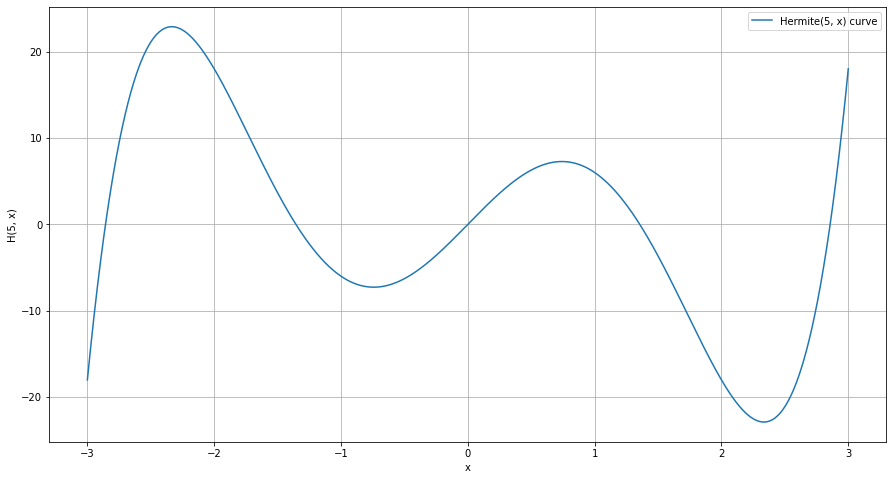

In [10]:
ns.plot_Hermite(5, -3, 3)

In [11]:
roots = ns.solveHermite(5)
N_roots = np.array(sp.N(sp.Matrix(roots))).astype(np.float64).reshape(-1)
print(ns.symHermite(5)[1], "的解为:")
for root in roots:
    print(root, end=", ")
print()
print("具体数值为:")
for root in N_roots:
    print(root, end=", ")

x**5 - 10*x**3 + 15*x 的解为:
0, -sqrt(5 - sqrt(10)), sqrt(5 - sqrt(10)), -sqrt(sqrt(10) + 5), sqrt(sqrt(10) + 5), 
具体数值为:
0.0, -1.355626179974266, 1.355626179974266, -2.8569700138728056, 2.8569700138728056, 

[1.33686841 0.55666179 0.55666179 0.02821815 0.02821815]


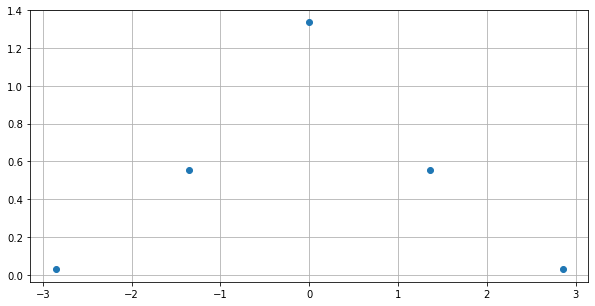

In [12]:
weights = ns.NodeWeight(5, N_roots)
print(weights)

fig = plt.figure(figsize=(10,5))
plt.plot(N_roots, weights, "o")
plt.grid(True)
fig.show()


In [13]:
k = 1/ns.RiemannIntegrate(-1e4, 1e4, n=1e7, prob = "prior")
posterior_var = ns.RiemannIntegrate(-1e4, 1e4, n=1e7, prob = "E_mu2") - (ns.RiemannIntegrate(-1e4, 1e4, n=1e7, prob = "E_mu"))**2
print("归一化常数为%f, mu的期望方差为%f"%(k, posterior_var))

归一化常数为3.715349, mu的期望方差为4.532931
